## Show the segmentation

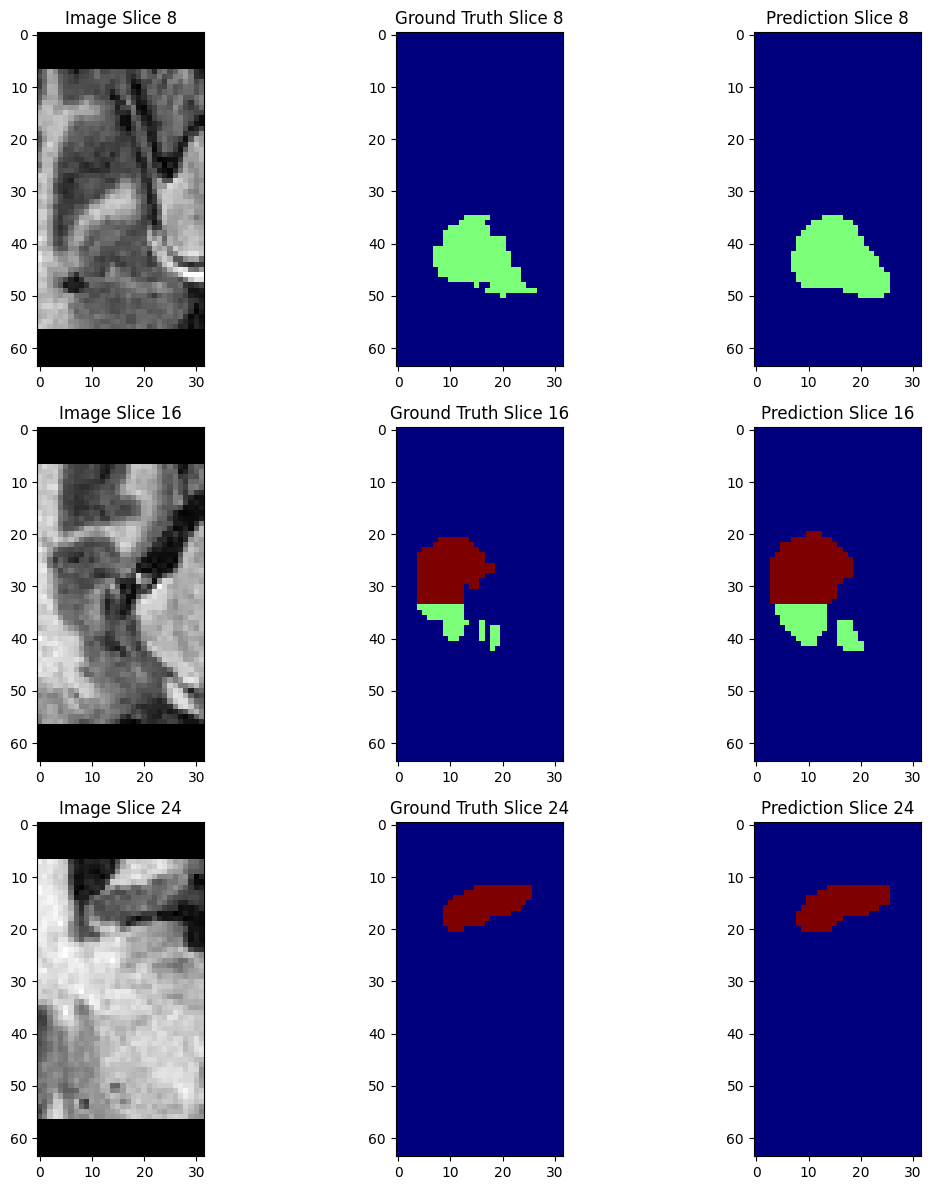

In [1]:
from ast import mod
import numpy as np
from omegaconf import DictConfig, OmegaConf
from typing import Dict, Tuple

import torch
import matplotlib.pyplot as plt

import data
from data.datasets import MedicalDecathlonDataset, BrainTumourDataset
from models.unet3d import UNet3D

task_name = "Task04_Hippocampus"
# task_name = "Task01_BrainTumour"
inference_model_name = "2025-03-12_22-04-21"
model_dir = f"trained_models/unet3d/{task_name}/{inference_model_name}"
model_path = f"{model_dir}/best_model.pth"

cfg = OmegaConf.load(f"{model_dir}/config.yaml")

model = UNet3D(
    in_channels=1,
    num_classes=cfg.dataset.num_classes,
    n_filters=cfg.model.n_filters,
    dropout=cfg.training.dropout,
    batch_norm=True,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location="cpu"))
model.to(device)  # Move the model to the appropriate device
model.eval()

if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

dataset = MedicalDecathlonDataset(cfg)
# dataset = BrainTumourDataset(cfg)

#samples idx list to check: (6,)
sample_idx = 15

image, gt = dataset[sample_idx]  # image: (C, D, H, W), gt: (D, H, W)

# Add batch dimension and move to device
image_batch = image.unsqueeze(0).to(device)  # shape: (1, C, D, H, W)

# Run inference
with torch.no_grad():
    output = model(image_batch)
    # If model returns deep supervision outputs, take the final prediction
    if isinstance(output, (tuple, list)):
        output = output[0]
    # Get predicted labels: (B, D, H, W)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu()  

# Convert tensors to numpy arrays for visualization
# Remove channel dimension from image for visualization: (D, H, W)
image_np = image.squeeze(0).cpu().numpy()
gt_np = gt.cpu().numpy()
pred_np = pred.numpy()

# Choose 3 slices evenly spaced along the depth dimension
num_slices = 3
depth = image_np.shape[0]
slice_indices = [int(depth * i / (num_slices + 1)) for i in range(1, num_slices + 1)]

# Create subplots: one row per slice and 3 columns for image, ground truth, and prediction
fig, axes = plt.subplots(nrows=num_slices, ncols=3, figsize=(12, 4 * num_slices))
for i, slice_idx in enumerate(slice_indices):
    slice_2d = image_np[slice_idx]
    # slice_2d = np.rot90(slice_2d)
    axes[i, 0].imshow(slice_2d, cmap="gray")
    axes[i, 0].set_title(f"Image Slice {slice_idx}")
    
    gt_2d = gt_np[slice_idx]
    # gt_2d = np.rot90(gt_2d)
    axes[i, 1].imshow(gt_2d, cmap="jet", vmin=0, vmax=cfg.dataset.num_classes - 1)

    axes[i, 1].set_title(f"Ground Truth Slice {slice_idx}")
    pred_2d = pred_np[slice_idx]
    # pred_2d = np.rot90(pred_2d)
    axes[i, 2].imshow(pred_2d, cmap="jet", vmin=0, vmax=cfg.dataset.num_classes - 1)
    axes[i, 2].set_title(f"Prediction Slice {slice_idx}")

    # for ax in axes[i]:
    #     ax.axis("off")



plt.tight_layout()
plt.show()

## Check the amount of classes

### Faster method - like 10 times faster

In [2]:
import nibabel as nib
import numpy as np
import os
from omegaconf import DictConfig, OmegaConf
from utils.utils import divide_dataset_config
from tqdm import tqdm  


cfg = OmegaConf.load("conf/config.yaml")
if not isinstance(cfg, DictConfig):
    raise TypeError("cfg must be a DictConfig.")

dataset_cfg, _ = divide_dataset_config(cfg)

labels_path = os.path.join(dataset_cfg.base_path, dataset_cfg.labels_subdir)
mask_files = sorted(os.listdir(labels_path))

def get_unique_labels(mask_file):
    mask_path = os.path.join(labels_path, mask_file)
    mask = nib.load(mask_path).get_fdata() 
    return np.unique(mask)  

all_labels = set()
for mask_file in tqdm(mask_files, desc="Processing masks"):
    unique_vals = get_unique_labels(mask_file)
    all_labels.update(unique_vals)  

print("Unique labels:", all_labels)
print("Number of unique labels:", len(all_labels))


ImportError: cannot import name 'divide_dataset_config' from 'utils.utils' (/home/si-hj/Desktop/medsegnet/utils/utils.py)